In [192]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import BallTree
import common_utils

# Bounds and parameters
lower_bound = 290.15  # Temperature in Kelvin
upper_bound = 320.15  # Temperature in Kelvin
no_data_percent = 0.20  # No data threshold
sample_size = 100000  # Number of random rows to sample

# MSG 2nd generation LST
msg_lst_data_file = "../msg_lu_fused_data_for_glm/concatenated_data.gpkg"

# Read the MSG LST data
msg_gdf = gpd.read_file(msg_lst_data_file)

# Ensure the CRS of both GeoDataFrames matches
msg_gdf = msg_gdf.to_crs("EPSG:4326")  # Change to the desired CRS if needed


# Convert temperature to Kelvin
msg_gdf['temperature'] = msg_gdf['temperature'] + 273.15

# Filter out rows outside the valid temperature range
msg_gdf = msg_gdf[(msg_gdf['temperature'] >= lower_bound) & (msg_gdf['temperature'] <= upper_bound)]

msg_gdf.head()

,time,lat,lon,temperature,hour,day,month,year,no_data,water,trees,flooded_veg,crop,built_area,bare_ground,snow_or_ice,clouds,range_land,geometry
0,2022-08-11 00:00:00,42.050003,12.250000,295.29,0,11,8,2022,0.132022,0.022978,0.044921,0.0,0.595550,0.189452,0.000000,0.0,0.0,0.015077,POINT (12.25 42.05)
1,2022-08-11 00:00:00,42.050003,12.300003,293.88,0,11,8,2022,0.177677,0.000143,0.036355,0.0,0.585212,0.182375,0.000000,0.0,0.0,0.018237,POINT (12.3 42.05)
2,2022-08-11 00:00:00,42.050003,12.349998,292.99,0,11,8,2022,0.178449,0.000134,0.055930,0.0,0.393311,0.332778,0.000000,0.0,0.0,0.039399,POINT (12.35 42.05)
3,2022-08-11 00:00:00,42.050003,12.400002,293.09,0,11,8,2022,0.177711,0.000164,0.100341,0.0,0.367734,0.314093,0.000000,0.0,0.0,0.039957,POINT (12.4 42.05)
4,2022-08-11 00:00:00,42.050003,12.450005,293.39,0,11,8,2022,0.177717,0.000030,0.122215,0.0,0.443907,0.223900,0.000002,0.0,0.0,0.032229,POINT (12.45 42.05)


-----------------------------
ECO2LSTE.001_SDS_LST_doy2023205153635_aid0001.gpkg
MSG data filtered for year: 2023, month: 7, day: 24, hour: 15
Number of rows in MSG data after filtering: 27
-----------------------------
ECO2LSTE.001_SDS_LST_doy2024227121521_aid0001.gpkg
No matching MSG LST data found for this timestamp. Skipping...
-----------------------------
ECO2LSTE.001_SDS_LST_doy2024226130329_aid0001.gpkg
No matching MSG LST data found for this timestamp. Skipping...
-----------------------------
ECO2LSTE.001_SDS_LST_doy2024214112149_aid0001.gpkg
No matching MSG LST data found for this timestamp. Skipping...
-----------------------------
ECO2LSTE.001_SDS_LST_doy2024164072532_aid0001.gpkg
No matching MSG LST data found for this timestamp. Skipping...
-----------------------------
ECO2LSTE.001_SDS_LST_doy2023164074859_aid0001.gpkg
MSG data filtered for year: 2023, month: 6, day: 13, hour: 7
Number of rows in MSG data after filtering: 27
-----------------------------
ECO2LSTE.001_SD

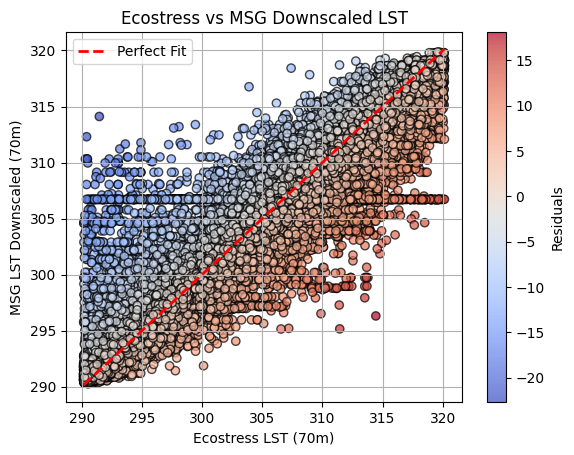

Feature Importances:
 msg_lst_temperature    0.870208
hour                   0.081997
month                  0.014391
built_area             0.013918
crop                   0.008098
trees                  0.006190
range_land             0.004264
water                  0.000936
dtype: float64
Root Mean Squared Error (RMSE): 2.13
RMSLE: 0.006993913789988256


In [193]:
# Directory containing the Ecostress files
ecostress_dir = "../ecostress_lulc_temprature_datetime_fused/"
file_extension = ".gpkg"

# Land use columns and target column
land_use_columns = [
    'water', 'trees', 'flooded_veg', 'crop',
    'built_area', 'bare_ground', 'snow_or_ice',
    'clouds', 'range_land'
]
columns_to_check = land_use_columns + ['no_data']
target = 'temperature'

# Initialize a GeoDataFrame to store all Ecostress data after merging LST from MSG
all_eco_stress_lst_data = gpd.GeoDataFrame()

# Iterate over all Ecostress files
for file_name in os.listdir(ecostress_dir):
    if file_name.endswith(file_extension):
        ecostress_file = os.path.join(ecostress_dir, file_name)

        # Read the file
        gdf = gpd.read_file(ecostress_file)

        # Filter rows based on land use and no_data columns
        gdf = gdf[~(gdf[columns_to_check] == 0).all(axis=1)]
        gdf = gdf[gdf['no_data'] <= no_data_percent]

        if gdf.shape[0] == 0:
            continue

        print("-----------------------------")
        print(file_name)

        # Convert temperature to Kelvin
        gdf['temperature'] = gdf['temperature'] + 273.15

        # Filter out rows outside the valid temperature range
        gdf = gdf[(gdf[target] >= lower_bound) & (gdf[target] <= upper_bound)]

        # Drop rows with missing values
        gdf = gdf.dropna(subset=['temperature'])

        if gdf.empty:
            continue

        # Randomly sample some rows
        if len(gdf) > sample_size:
            gdf = gdf.sample(n=sample_size)

        # Filter msg_gdf by year, month, day and hour
        match_time = (
            (msg_gdf['year'] == gdf['year'].iloc[0]) &
            (msg_gdf['month'] == gdf['month'].iloc[0]) &
            (msg_gdf['day'] == gdf['day'].iloc[0]) &
            (msg_gdf['hour'] == gdf['hour'].iloc[0])
        )
        msg_gdf_filtered = msg_gdf[match_time]

        if msg_gdf_filtered.empty:
            print("No matching MSG LST data found for this timestamp. Skipping...")
            continue

        print(f"MSG data filtered for year: {gdf['year'].iloc[0]}, month: {gdf['month'].iloc[0]}, day: {gdf['day'].iloc[0]}, hour: {gdf['hour'].iloc[0]}")
        print(f"Number of rows in MSG data after filtering: {msg_gdf_filtered.shape[0]}")

        # Match MSG LST temperature by nearest geometry and time
        msg_coords = np.radians(np.array(list(zip(msg_gdf_filtered.geometry.x, msg_gdf_filtered.geometry.y))))
        ecostress_coords = np.radians(np.array(list(zip(gdf.geometry.x, gdf.geometry.y))))
        tree = BallTree(msg_coords, metric='haversine')

        # Find the nearest neighbors
        distances, indices = tree.query(ecostress_coords, k=1)
        gdf['msg_lst_temperature'] = msg_gdf_filtered.iloc[indices.flatten()]['temperature'].reset_index(drop=True).values

        # Append processed data to the master GeoDataFrame
        all_eco_stress_lst_data = pd.concat([all_eco_stress_lst_data, gdf], ignore_index=True)


# Proceed with model training and analysis
# Define LULC columns (all columns except the target)
predictors = ['trees', 'water', 'crop', 'built_area', 'range_land', 'msg_lst_temperature', 'month', 'hour']

# Drop rows with missing values in predictors
all_eco_stress_lst_data = all_eco_stress_lst_data.dropna(subset=predictors)
data = all_eco_stress_lst_data

# 1. Prepare the data
X = data[predictors]
y = data['temperature']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 4. Train the model
rf_model.fit(X_train, y_train)

# 5. Make predictions
y_pred = rf_model.predict(X_test)

# Plot observed vs predicted
residuals = y_test - y_pred
sc = plt.scatter(y_test, y_pred, c=residuals, cmap='coolwarm', alpha=0.7, edgecolor='k')

# Add a color bar for residuals
plt.colorbar(sc, label='Residuals')

# Add a diagonal line for reference (perfect prediction line)
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

# Add labels, title, and legend
plt.xlabel('Ecostress LST (70m)')
plt.ylabel('MSG LST Downscaled (70m)')
plt.title('Ecostress vs MSG Downscaled LST')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# 6. Feature importance (optional)
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print("Feature Importances:\n", feature_importances.sort_values(ascending=False))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Assuming a function common_utils.calculate_rmsle exists for calculating RMSLE
rmsle_value = common_utils.calculate_rmsle(y_test, y_pred)
print(f"RMSLE: {rmsle_value}")

In [194]:
from joblib import dump

# Save the trained model to a file
model_filename = "random_forest_model.pkl"
dump(rf_model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to random_forest_model.pkl


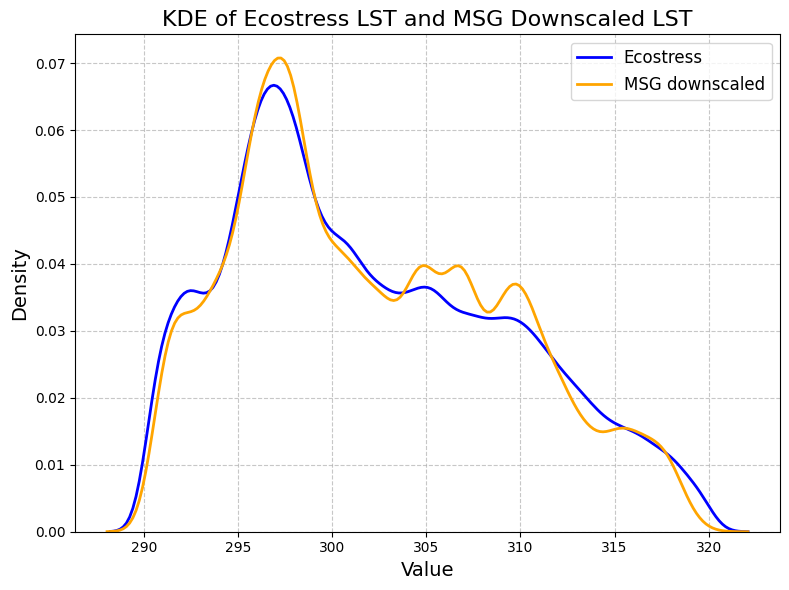

In [195]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Create the plot
plt.figure(figsize=(8, 6))

# Plot KDE for observed values
sns.kdeplot(y_train, color='blue', linewidth=2, label='Ecostress')

# Plot KDE for predicted values
sns.kdeplot(y_pred, color='orange', linewidth=2, label='MSG downscaled')

# Add labels and legend
plt.title("KDE of Ecostress LST and MSG Downscaled LST", fontsize=16)
plt.xlabel("Value", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()